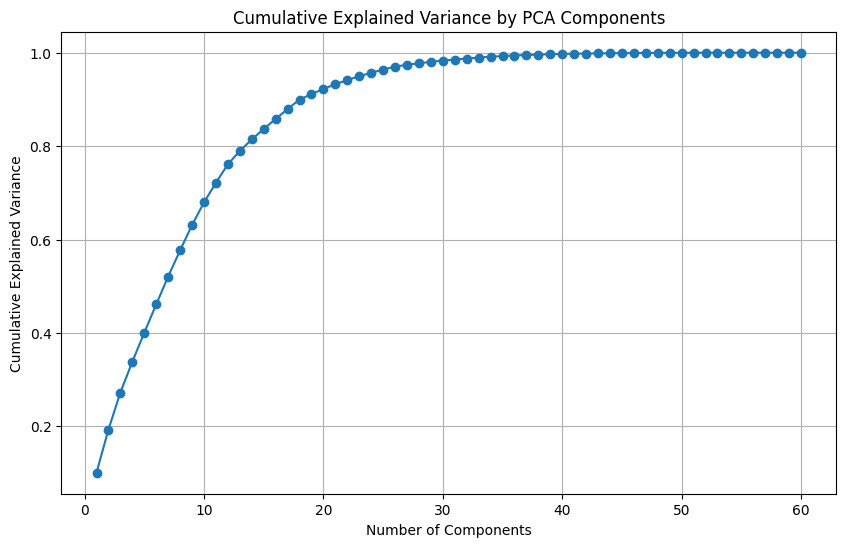

Selected 24 components to retain at least 95% of the variance.
Threshold score at 90.0% percentile: 0.58


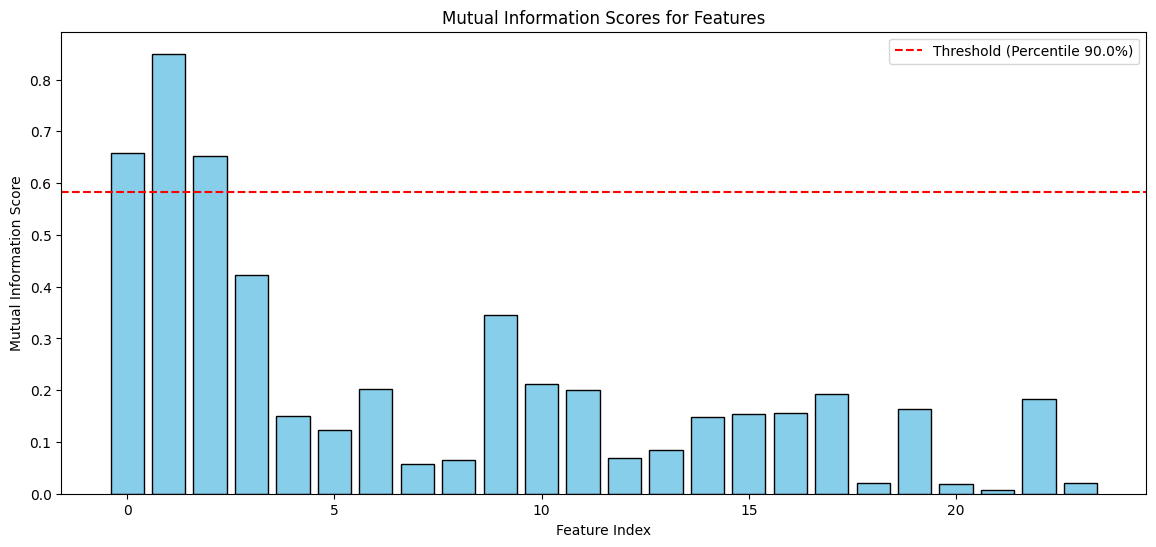

Selected feature indices: [0, 1, 2]
Number of selected features: 3


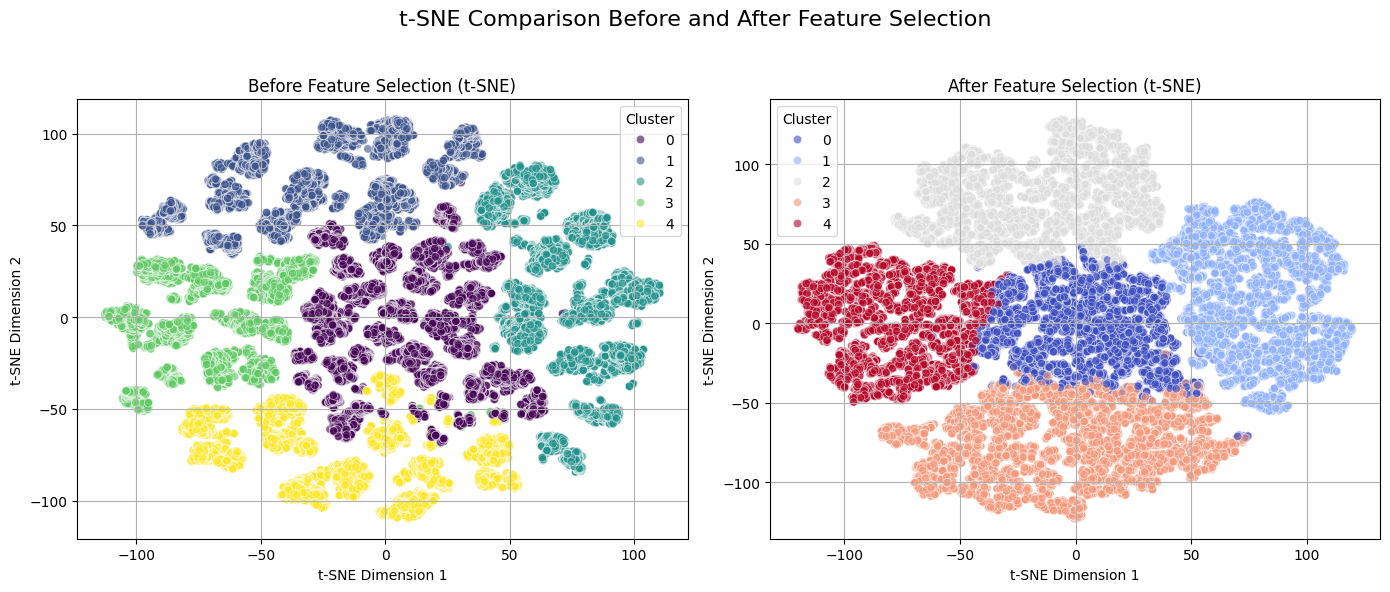

K-means Davies-Bouldin Index: 0.69
Hierarchical Davies-Bouldin Index: 0.75
DBSCAN did not find any clusters (only noise).
GMM Davies-Bouldin Index: 0.82
 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.22091692473760566
Fuzzy C-Means Davies-Bouldin Index: 0.69


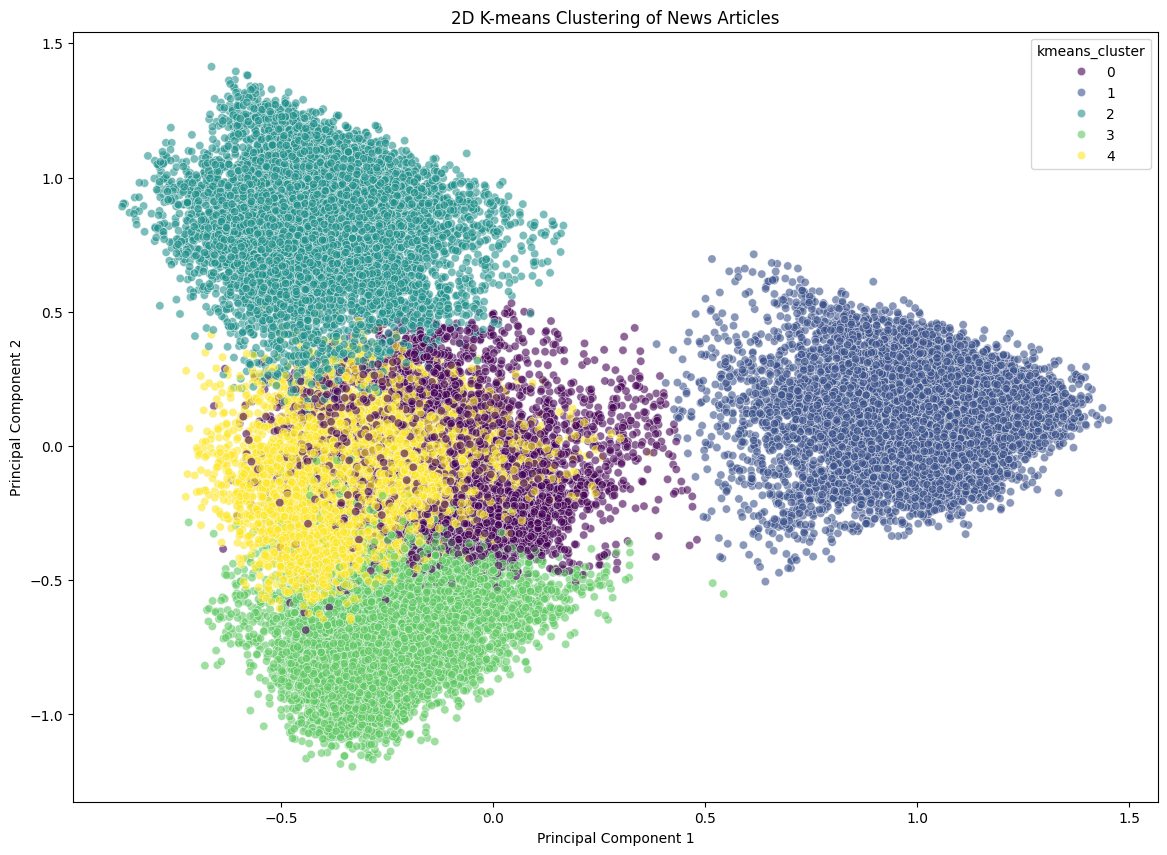

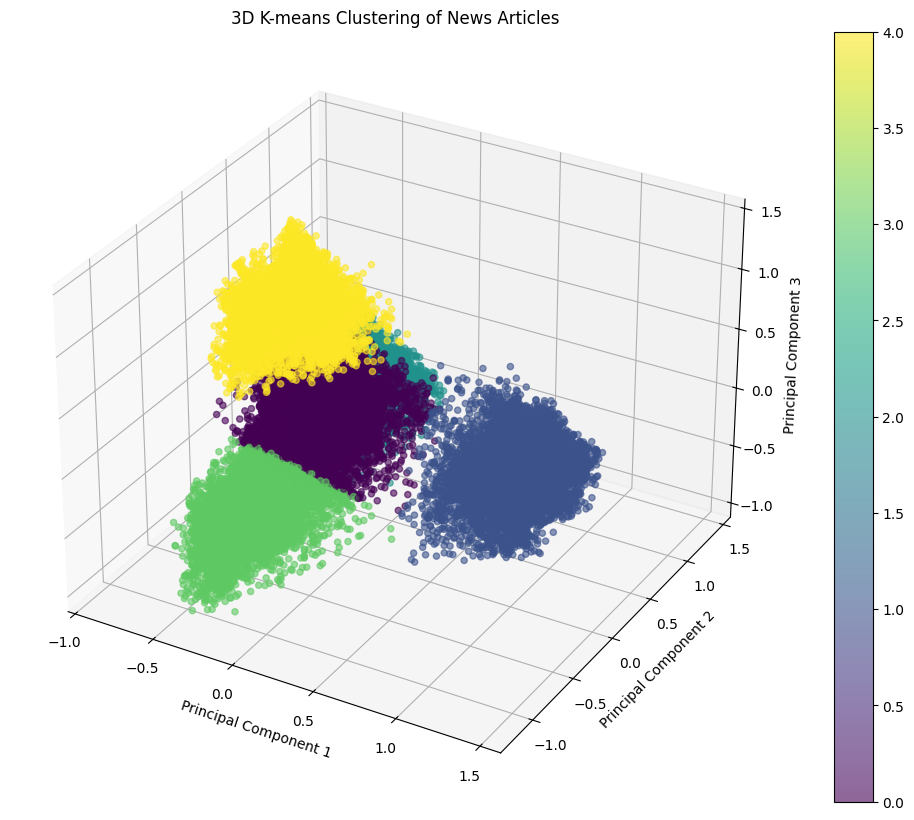

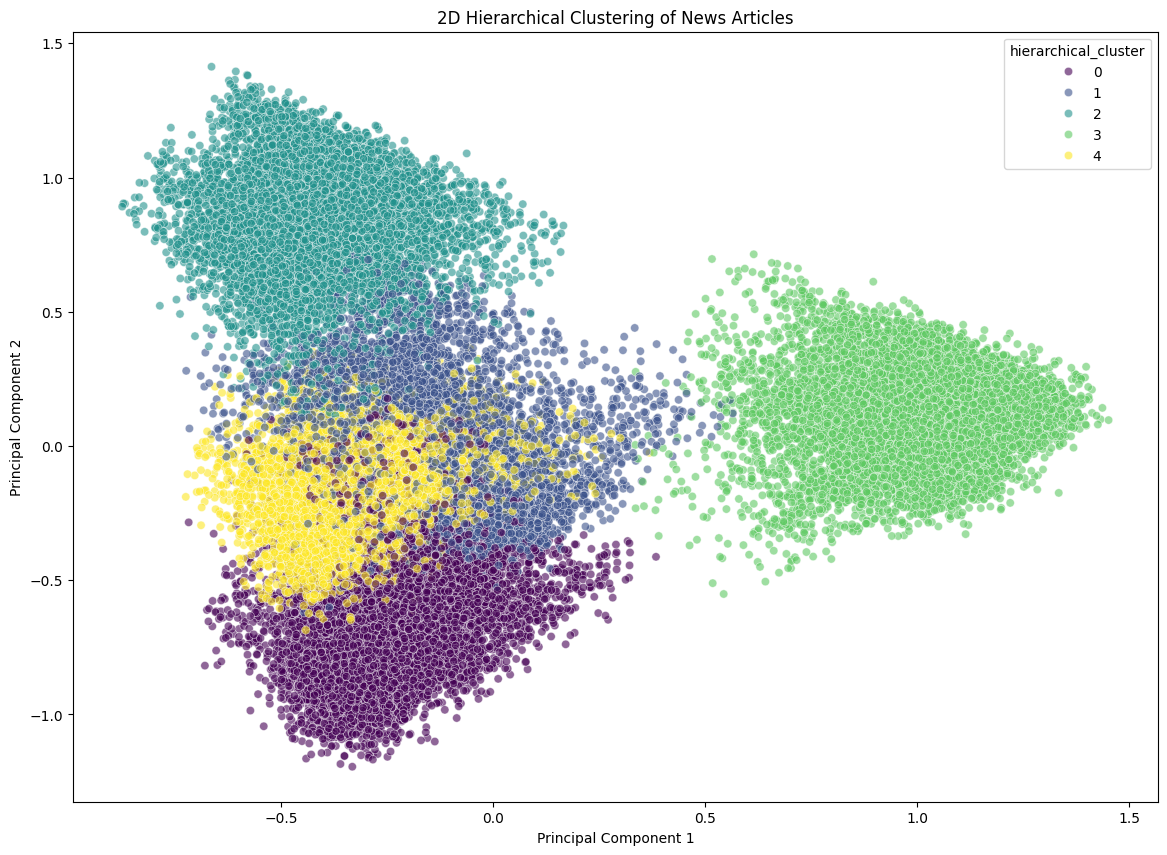

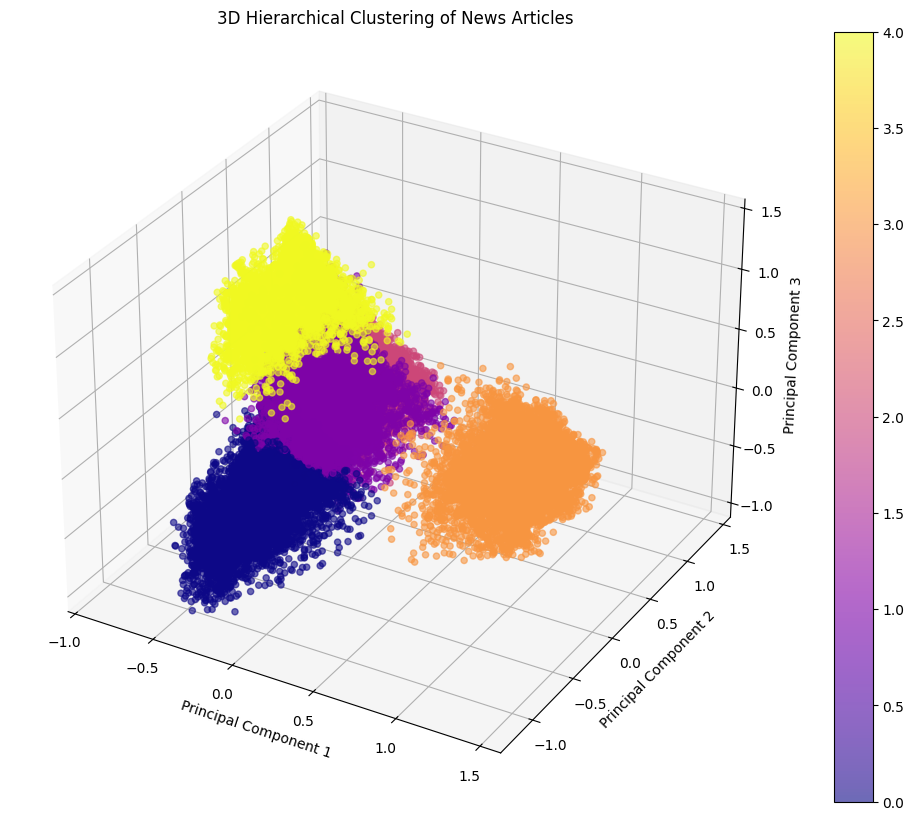

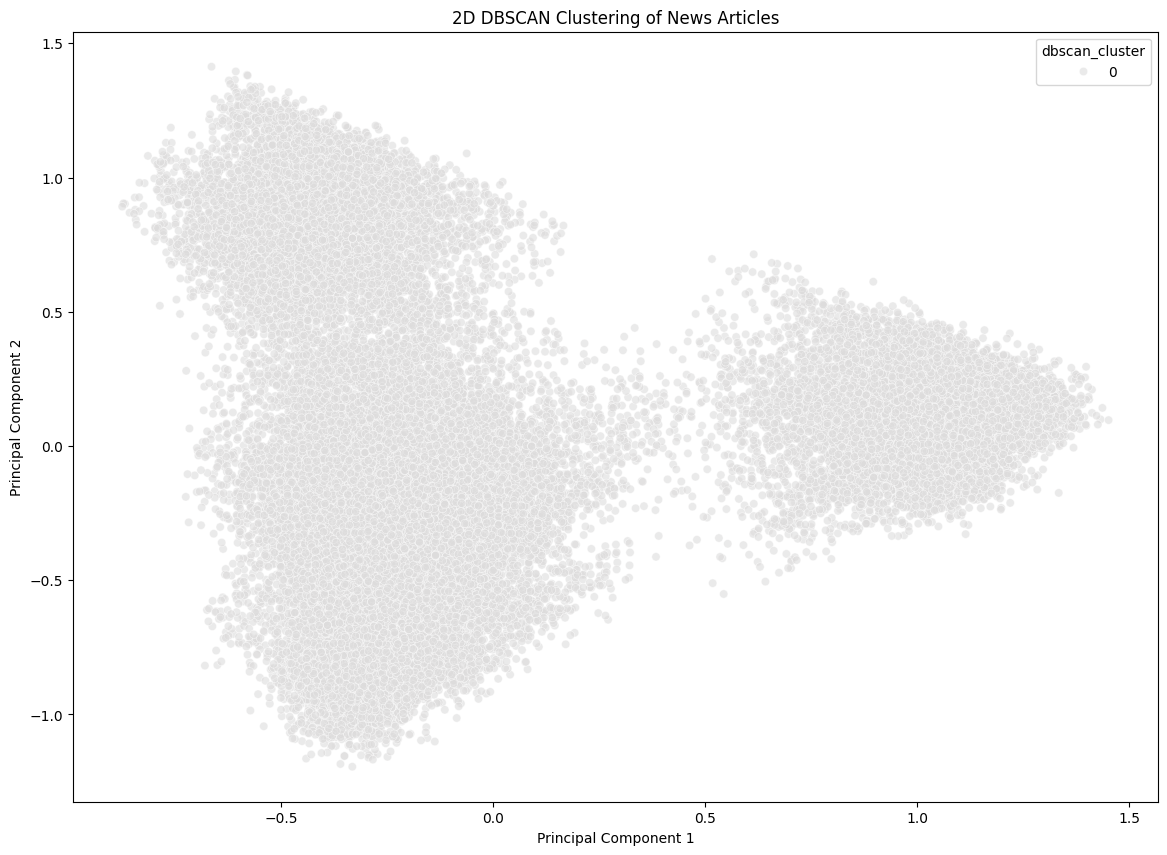

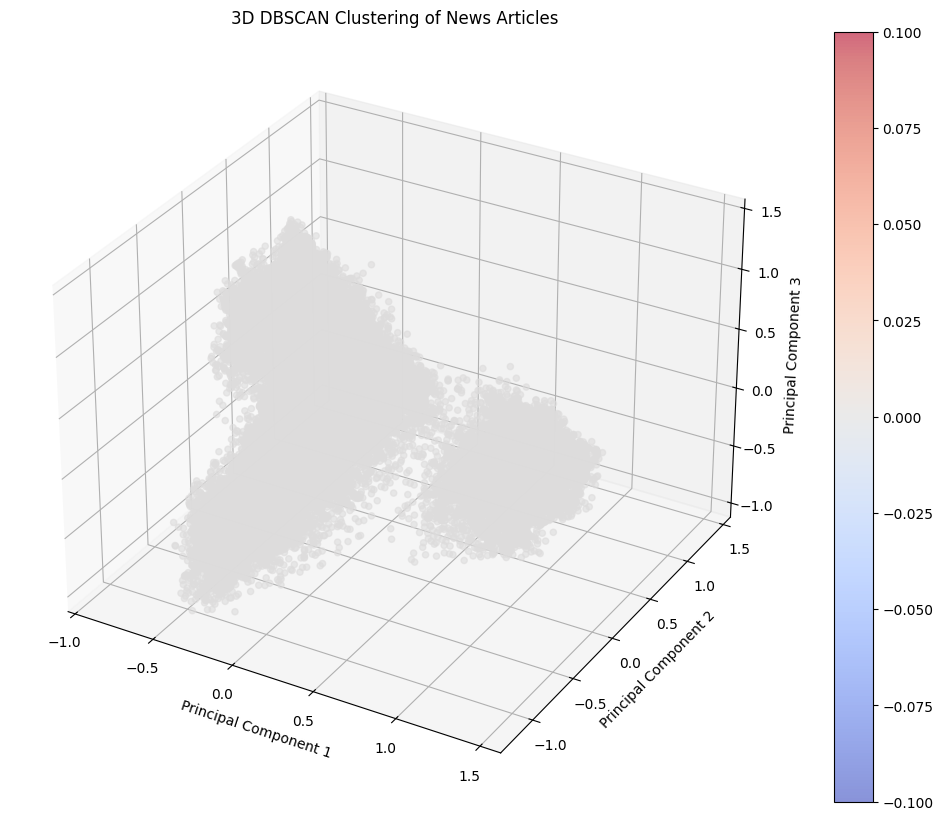

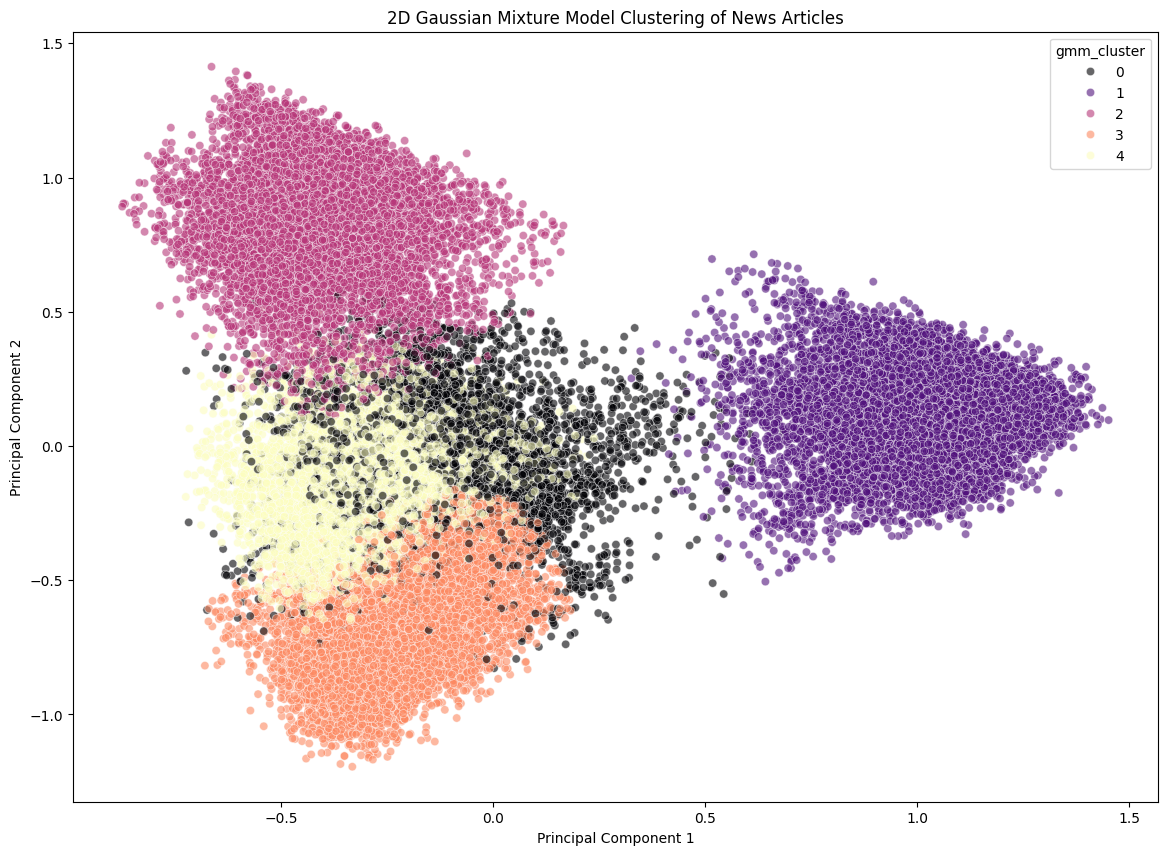

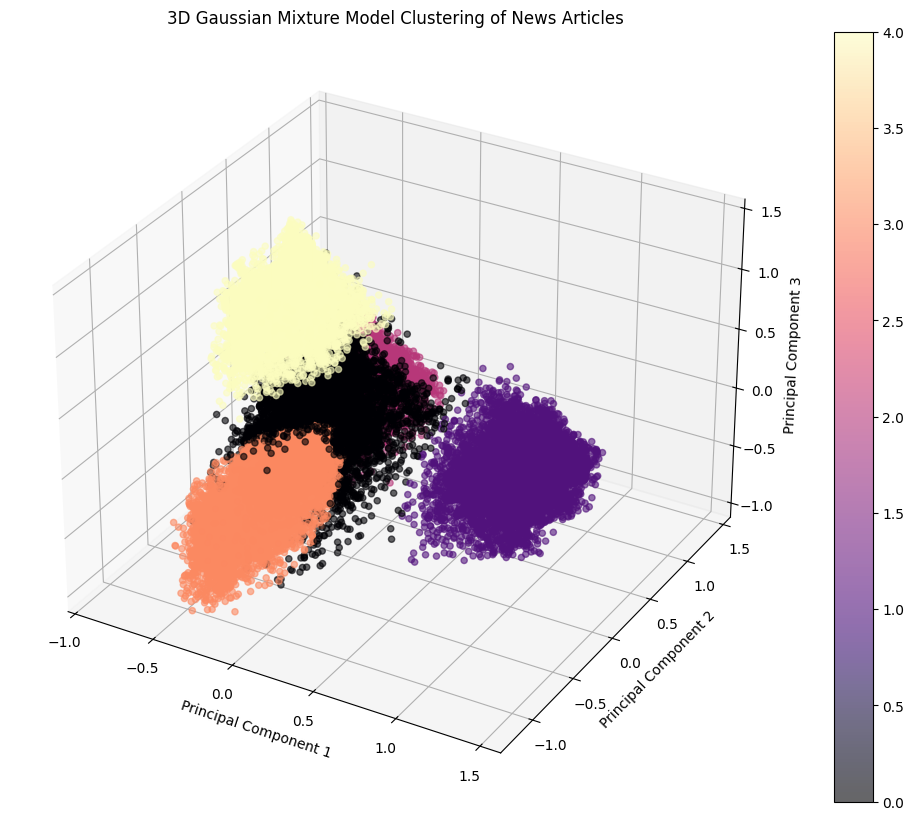

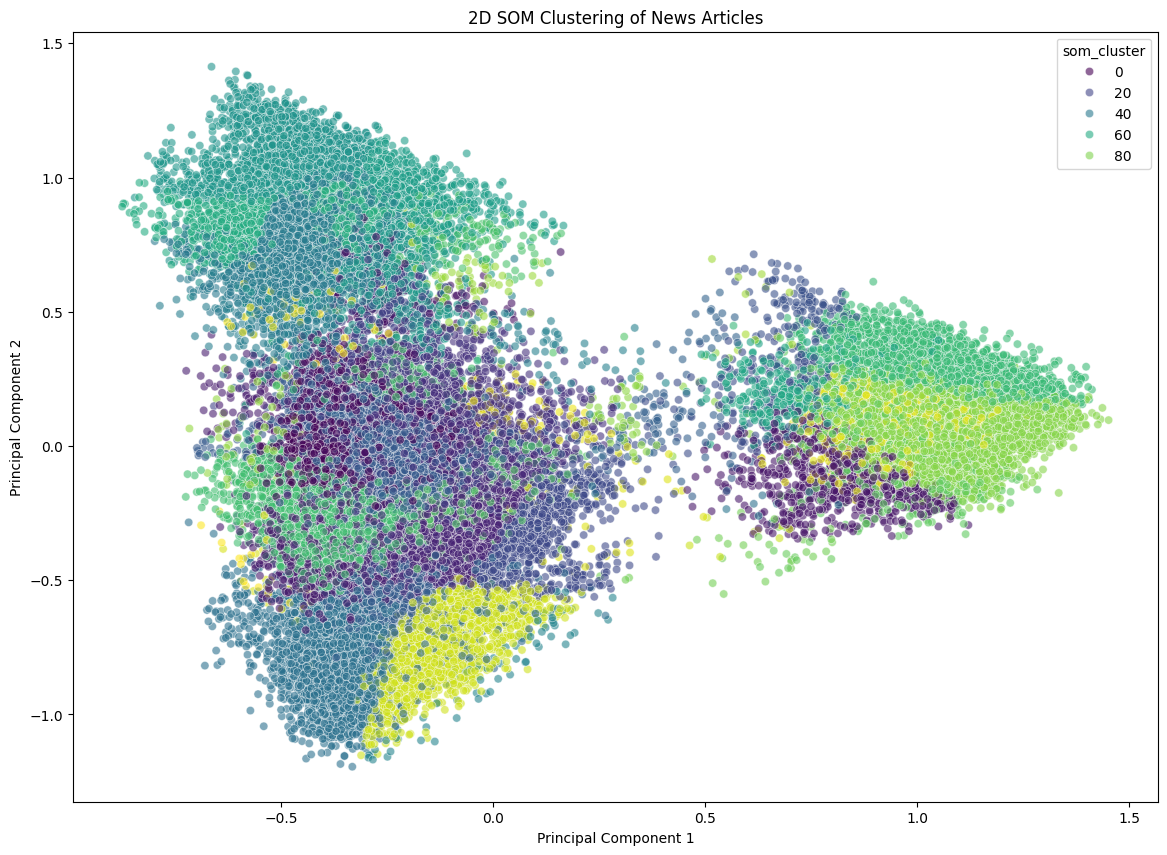

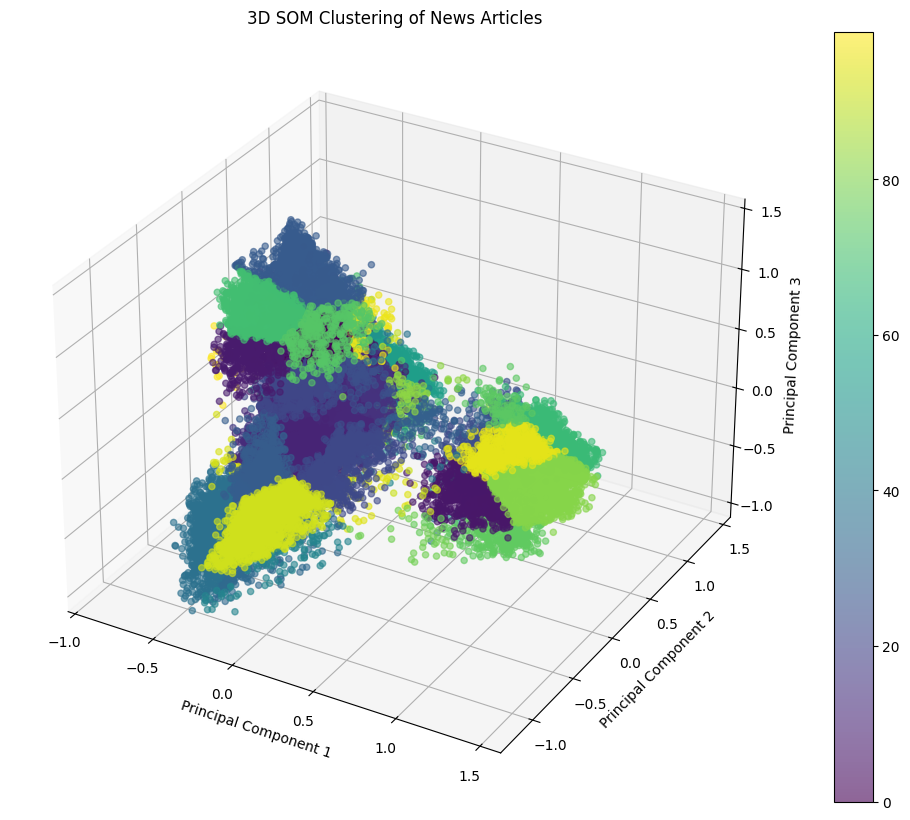

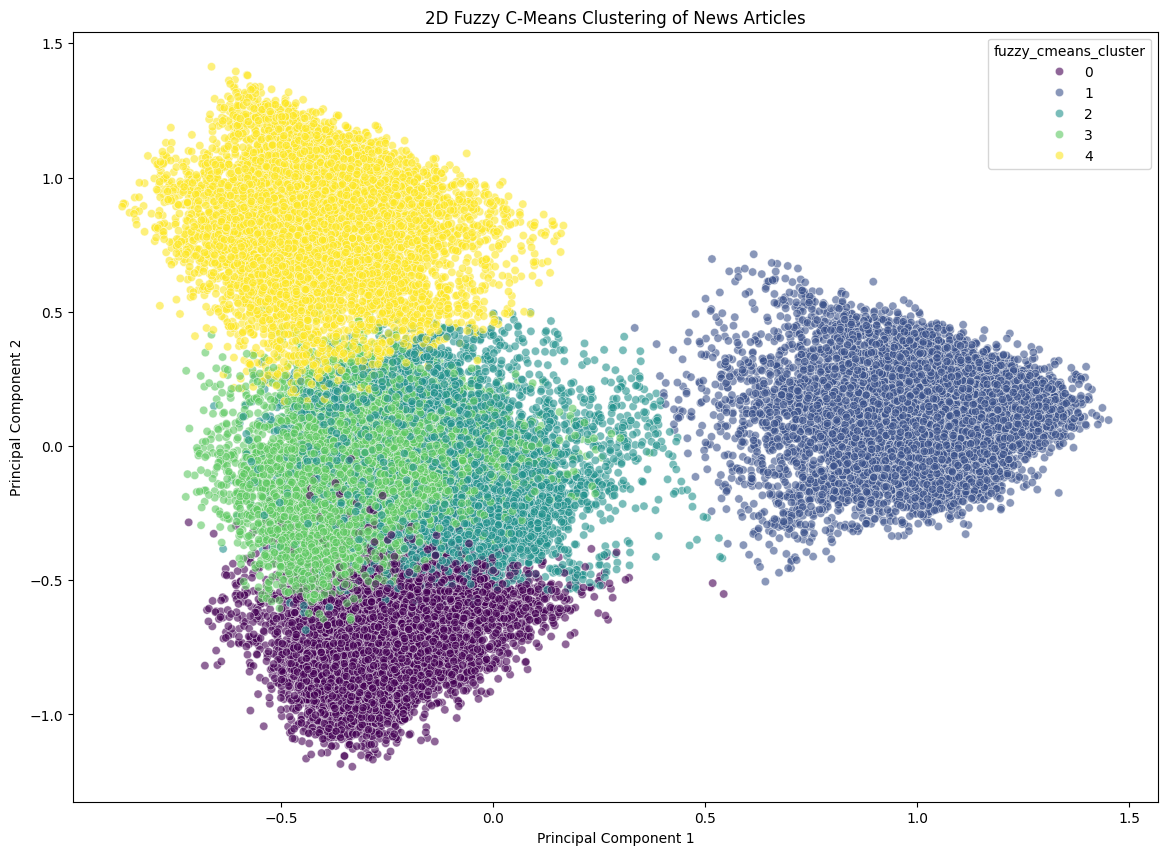

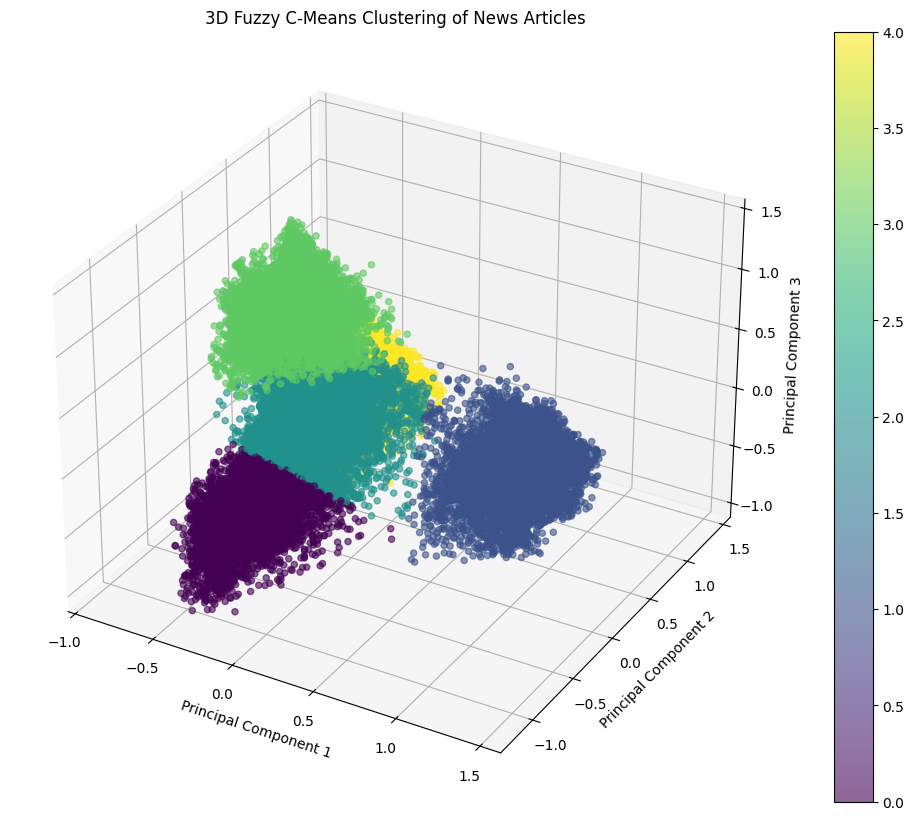

In [ ]:
# region imports og config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler  # Normalization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from minisom import MiniSom  # Self-Organizing Map
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz  # Fuzzy C-Means Clustering
from itertools import combinations
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
import numpy as np

pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

df = pd.read_csv(os.path.join('..', '..', 'data', 'Social-media', 'OnlineNewsPopularity.csv'))
# endregion

# region preprocess 
# Drop missing values if any
df = df.dropna()

# Select relevant numerical columns for clustering
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Normalize the features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[numeric_cols])
# endregion

# region extraction
# Step 3: Dimensionality Reduction (show cumulative variance before selecting components)
pca = PCA()
pca_fit = pca.fit(df_normalized)
explained_variance = np.cumsum(pca_fit.explained_variance_ratio_)

# Plot cumulative variance explained by PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Select enough components to retain at least 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1  # Add 1 because of 0-based indexing
pca = PCA(n_components=n_components)
pca_fit = pca.fit(df_normalized)
reduced_data = pca.transform(df_normalized)

print(f'Selected {n_components} components to retain at least 95% of the variance.')
# endregion

# region selection
def filter_feature_selection(data, n_clusters, percentile=0.75):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    mi_scores = mutual_info_classif(data, labels, discrete_features=False)
    threshold_score = np.percentile(mi_scores, percentile * 100)
    print(f"Threshold score at {percentile*100}% percentile: {threshold_score:.2f}")
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(mi_scores)), mi_scores, color='skyblue', edgecolor='black')
    plt.axhline(y=threshold_score, color='red', linestyle='--', label=f'Threshold (Percentile {percentile*100}%)')
    plt.xlabel('Feature Index')
    plt.ylabel('Mutual Information Score')
    plt.title('Mutual Information Scores for Features')
    plt.legend()
    plt.show()
    return [i for i, score in enumerate(mi_scores) if score >= threshold_score]

n_clusters = 5
percentile = 0.9
selected_features = filter_feature_selection(reduced_data, n_clusters, percentile=percentile)
print(f"Selected feature indices: {selected_features}")
print(f"Number of selected features: {len(selected_features)}")
reduced_data_selected = reduced_data[:, selected_features]
# endregion

# region tsne, visualisere selection
# Visualization: t-SNE Comparison Before and After Feature Selection
def plot_tsne_comparison(data_full, labels_full, data_selected, labels_selected, title):
    """
    Visualize clustering structure before and after feature selection using t-SNE.

    Parameters:
    - data_full: np.ndarray, full PCA data
    - labels_full: np.ndarray, cluster labels for full data
    - data_selected: np.ndarray, data after feature selection
    - labels_selected: np.ndarray, cluster labels for selected data
    - title: str, overall title for the plot
    """
    tsne_full = TSNE(n_components=2, random_state=42).fit_transform(data_full)
    tsne_selected = TSNE(n_components=2, random_state=42).fit_transform(data_selected)

    plt.figure(figsize=(14, 6))

    # t-SNE for full data
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x=tsne_full[:, 0],
        y=tsne_full[:, 1],
        hue=labels_full,
        palette="viridis",
        alpha=0.6,
    )
    plt.title("Before Feature Selection (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.grid()

    # t-SNE for selected data
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x=tsne_selected[:, 0],
        y=tsne_selected[:, 1],
        hue=labels_selected,
        palette="coolwarm",
        alpha=0.6,
    )
    plt.title("After Feature Selection (t-SNE)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster")
    plt.grid()

    # Add a main title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Perform clustering on full PCA data
kmeans_full = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_data)
labels_full = kmeans_full.labels_

# Perform clustering on selected features
kmeans_selected = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_data_selected)
labels_selected = kmeans_selected.labels_

# Plot the comparison
plot_tsne_comparison(
    reduced_data,
    labels_full,
    reduced_data_selected,
    labels_selected,
    "t-SNE Comparison Before and After Feature Selection"
)
# endregion

# region algos
# **Algorithm 1: K-means Clustering**
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(reduced_data_selected[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate K-means clustering using Davies-Bouldin Index
kmeans_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['kmeans_cluster'])
print(f'K-means Davies-Bouldin Index: {kmeans_davies_bouldin:.5f}')

# **Algorithm 2: Hierarchical Clustering**
hierarchical = AgglomerativeClustering(n_clusters=5)
df['hierarchical_cluster'] = hierarchical.fit_predict(reduced_data_selected[:, :3])

# Evaluate Hierarchical clustering using Davies-Bouldin Index
hierarchical_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['hierarchical_cluster'])
print(f'Hierarchical Davies-Bouldin Index: {hierarchical_davies_bouldin:.5f}')

# **Algorithm 3: DBSCAN Clustering**
dbscan = DBSCAN(eps=100, min_samples=1)
df['dbscan_cluster'] = dbscan.fit_predict(reduced_data_selected[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate DBSCAN clustering using Davies-Bouldin Index (only if clusters are found)
if len(set(df['dbscan_cluster'])) > 1:
    dbscan_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['dbscan_cluster'])
    print(f'DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin:.5f}')
else:
    print('DBSCAN did not find any clusters (only noise).')

# **Algorithm 4: Gaussian Mixture Model (GMM)**
gmm = GaussianMixture(n_components=5, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(reduced_data_selected[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate GMM clustering using Davies-Bouldin Index
gmm_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['gmm_cluster'])
print(f'GMM Davies-Bouldin Index: {gmm_davies_bouldin:.5f}')

# **Algorithm 5: Self-Organizing Map (SOM)**
som = MiniSom(x=10, y=10, input_len=reduced_data_selected.shape[1], sigma=1.0, learning_rate=0.5)
som.train(reduced_data_selected, 100, verbose=True)

# Get the winning neuron for each data point
winning_positions = np.array([som.winner(data) for data in reduced_data_selected])
df['som_cluster'] = [pos[0] * 10 + pos[1] for pos in winning_positions]

# **Algorithm 6: Fuzzy C-Means Clustering**
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(reduced_data_selected.T, c=5, m=2, error=1e-5, maxiter=1000, init=None)

# Assign cluster labels to the DataFrame
df['fuzzy_cmeans_cluster'] = np.argmax(u, axis=0)

# Evaluate Fuzzy C-Means clustering using Davies-Bouldin Index
if len(set(df['fuzzy_cmeans_cluster'])) > 1:
    fuzzy_cmeans_davies_bouldin = davies_bouldin_score(reduced_data_selected[:, :3], df['fuzzy_cmeans_cluster'])
    print(f'Fuzzy C-Means Davies-Bouldin Index: {fuzzy_cmeans_davies_bouldin:.5f}')
else:
    print('Fuzzy C-Means did not find any clusters (only noise).')
# endregion

# region plotting
# 2D K-means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['kmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D K-means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D Hierarchical plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['hierarchical_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Hierarchical Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Hierarchical plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['hierarchical_cluster'], cmap='plasma', alpha=0.6)
plt.title('3D Hierarchical Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D DBSCAN plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['dbscan_cluster'], palette='coolwarm', alpha=0.6)
plt.title('2D DBSCAN Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D DBSCAN plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['dbscan_cluster'], cmap='coolwarm', alpha=0.6)
plt.title('3D DBSCAN Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D GMM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['gmm_cluster'], palette='magma', alpha=0.6)
plt.title('2D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D GMM plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['gmm_cluster'], cmap='magma', alpha=0.6)
plt.title('3D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D SOM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['som_cluster'], palette='viridis', alpha=0.6)
plt.title('2D SOM Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D SOM plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['som_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D SOM Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D Fuzzy C-Means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data_selected[:, 0], y=reduced_data_selected[:, 1], hue=df['fuzzy_cmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Fuzzy C-Means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Fuzzy C-Means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data_selected[:, 0], reduced_data_selected[:, 1], reduced_data_selected[:, 2], c=df['fuzzy_cmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D Fuzzy C-Means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()
# endregion 